DECISION TREE !!!!

These are used for both classification and regression tasks. It creates a tree-like structure by splitting the dataset into subsets based on feature values, they do not require feature scaling but can easily be prone to overfitting if the depth is not controlled.

SCRATCH IMPLEMENTATION on Iris DATASET !! (Classification task)

Training Accuracy: 0.9583333333333334
Test Accuracy: 1.0


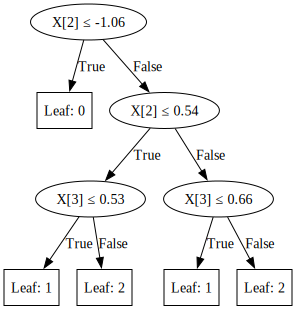

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from graphviz import Digraph


def gini(y):
    classes = np.unique(y)
    impurity = 1.0
    for cls in classes:
        p = np.sum(y == cls) / len(y)
        impurity -= p ** 2
    return impurity

def best_split(X, y):
    best_feature, best_threshold, best_gini = None, None, 1.0
    n_samples, n_features = X.shape

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left = y[X[:, feature] <= threshold]
            right = y[X[:, feature] > threshold]

            if len(right) == 0 or len(left) ==0:
                continue

            gini_left = gini(left)
            gini_right = gini(right)
            weighted_gini = (len(right) * gini(right) + len(left) * gini(left)) / len(y)

            if weighted_gini < best_gini:
             best_gini = weighted_gini
             best_feature = feature
             best_threshold = threshold

    return best_feature , best_threshold

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def build_tree(X,y, depth = 0, max_depth = 5):
    if len(set(y)) == 1 or depth >= max_depth:
        most_common = np.bincount(y).argmax()
        return Node(value = most_common)

    feature, threshold = best_split(X, y)
    if feature is None:
        most_common = np.bincount(y).argmax()
        return Node(value = most_common)

    left_indices = X[:, feature] <= threshold
    right_indices = X[:,feature] > threshold

    left_subtree = build_tree(X[left_indices], y[left_indices], depth + 1, max_depth = 3)
    right_subtree = build_tree(X[right_indices], y[right_indices], depth + 1, max_depth = 3)

    return Node(feature, threshold, left_subtree, right_subtree)

def predict(sample, tree):
    if tree.value is not None:
        return tree.value
    if sample[tree.feature] <= tree.threshold:
        return predict(sample, tree.left)
    else:
        return predict(sample, tree.right)

def predict_all(X, tree):
    return np.array([predict(sample, tree) for sample in X])

df = pd.read_csv("../data/Iris.csv")
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

le = LabelEncoder()
y = le.fit_transform(y)

X = (X - X.mean(axis=0)) / X.std(axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = build_tree(X_train, y_train, max_depth=3)

train_preds = predict_all(X_train, tree)
test_preds = predict_all(X_test, tree)

train_acc = np.mean(train_preds == y_train)
test_acc = np.mean(test_preds == y_test)

print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

def visualize_tree(node, dot=None, counter=[0]):
    if dot is None:
        dot = Digraph()
    
    node_id = str(counter[0])
    counter[0] += 1

    if node.value is not None:
        dot.node(node_id, f"Leaf: {node.value}", shape="box")
        return dot, node_id

    dot.node(node_id, f"X[{node.feature}] ≤ {round(node.threshold, 2)}")

    dot, left_id = visualize_tree(node.left, dot, counter)
    dot.edge(node_id, left_id, label="True")

    dot, right_id = visualize_tree(node.right, dot, counter)
    dot.edge(node_id, right_id, label="False")

    return dot, node_id

dot, _ = visualize_tree(tree)
dot 

Using SCIKIT-LEARN !! (less stressful huh...)

Training accuracy:  0.9583333333333334
Test accuracy:  1.0


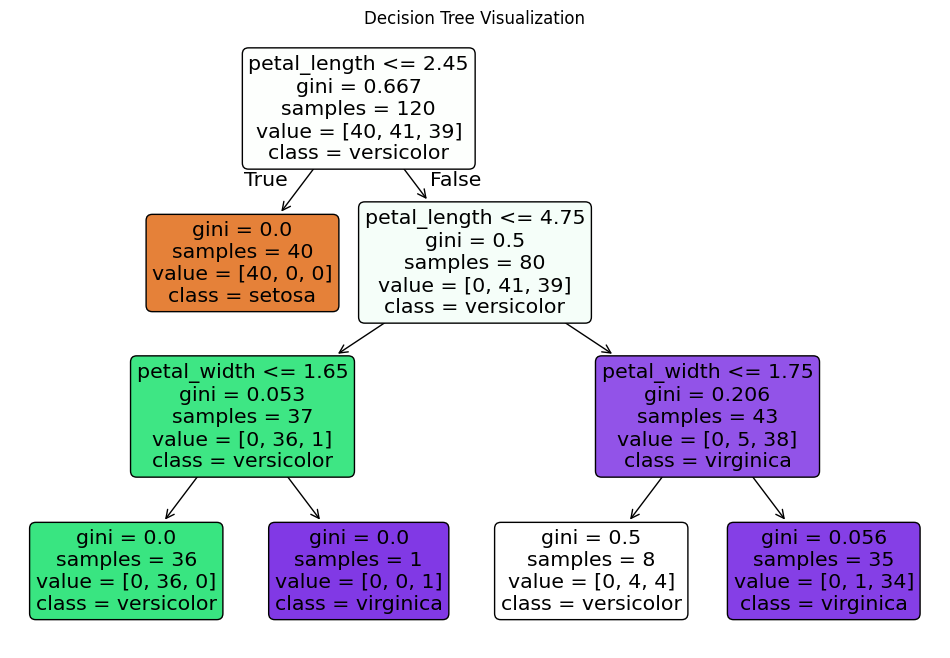

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

df = pd.read_csv("../data/Iris.csv")
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train,y_train)

train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc = accuracy_score(y_test, clf.predict(X_test))
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

plt.figure(figsize=(12, 8))
plot_tree(clf, 
          feature_names=df.columns[:-1], 
          class_names=clf.classes_, 
          filled=True, 
          rounded=True)
plt.title("Decision Tree Visualization")
plt.show()